In [1]:
from dredFISH.Analysis.TissueGraph import *
from dredFISH.Analysis.Taxonomy import *

from MERFISH_Objects.FISHData import *

from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt 

%load_ext line_profiler

In [2]:
base_path = '/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/'
dataset = 'DPNMF_PolyA_2021Nov19'
fishdata = FISHData(os.path.join(base_path,'fishdata'))
data = fishdata.load_data('h5ad',dataset=dataset)
data.obs_names_make_unique()

data.X = data.layers['total_vectors']
data = data[np.isnan(data.X.max(1))==False]

data.X = data.X/data.obs['total_signal'][:,None]
data.X = data.X - np.array([np.percentile(data.X[:,i],25) for i in range(data.X.shape[1])])
data.X = data.X / np.array([np.percentile(data.X[:,i],75) for i in range(data.X.shape[1])])
data.X = normalize(data.X)

XY = np.asarray([data.obs['stage_y'], data.obs['stage_x']])
XY = np.transpose(XY)
data.obsm['stage'] = XY

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/tmp/ipykernel_2067894/676460092.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  data.X = data.X/data.obs['total_signal'][:,None]


In [3]:
TMG = TissueMultiGraph()
TMG.ScalarEnvSize = 5
TMG.createCellAndZoneLayers(XY,data.X,initRes = 7.15416)


Build similarity graph 
calculation took: 0.61
Calling initial optimization
calculation took: 0.62
Initial types found: 107


In [4]:
TMG.Layers = TMG.Layers[0:2]
TMG.addEnvironmentLayer(12)


Treenomial mixture model training:


/home/rwollman/MyProjects/MaximallyInformativeBiocartography/dredFISH/dredFISH/Analysis/Taxonomy.py:350: RuntimeWarning: invalid value encountered in true_divide
  q = q_no/q_deno


epoch: 0 likelihood: -588591.20 time: 6.50
epoch: 1 likelihood: -348244.07 time: 12.95
epoch: 2 likelihood: -303443.30 time: 19.39
epoch: 3 likelihood: -287409.65 time: 25.93
epoch: 4 likelihood: -279866.43 time: 32.42
epoch: 5 likelihood: -273943.94 time: 38.79
epoch: 6 likelihood: -269192.46 time: 45.32
epoch: 7 likelihood: -265911.75 time: 51.52
epoch: 8 likelihood: -262721.72 time: 58.01
epoch: 9 likelihood: -259807.60 time: 64.44
epoch: 10 likelihood: -258024.12 time: 70.66
Cvec: 12 Cond Entropy: 9.02


In [5]:
Ent = [l.CondEntropy() for l in TMG.Layers]
print(Ent)

[9.974100838578002, 9.118232674240609, 9.020494045504272]


Ntypes: 12 Nenv: 7364 Ez: 12.57Et: 3.55 Log2(Nenv) 12.85 Log2(Ntyp) 3.58


(array([341.,  68.,  69., 137.,  69.,  69., 137., 276., 276.,  69., 482.,
        206., 138., 275., 276., 206., 413., 413., 207., 206., 274., 207.,
        207.,  69., 137., 344.,  69.,  69., 207.,   0.,   0., 138.,   0.,
         69., 138., 207., 138., 207.,  69.,  69.,  68.,  69.,   0.,   0.,
          0.,  69.,   0., 138.,   0.,  69.]),
 array([   3017. ,   26535.1,   50053.2,   73571.3,   97089.4,  120607.5,
         144125.6,  167643.7,  191161.8,  214679.9,  238198. ,  261716.1,
         285234.2,  308752.3,  332270.4,  355788.5,  379306.6,  402824.7,
         426342.8,  449860.9,  473379. ,  496897.1,  520415.2,  543933.3,
         567451.4,  590969.5,  614487.6,  638005.7,  661523.8,  685041.9,
         708560. ,  732078.1,  755596.2,  779114.3,  802632.4,  826150.5,
         849668.6,  873186.7,  896704.8,  920222.9,  943741. ,  967259.1,
         990777.2, 1014295.3, 1037813.4, 1061331.5, 1084849.6, 1108367.7,
        1131885.8, 1155403.9, 1178922. ]),
 <BarContainer object o

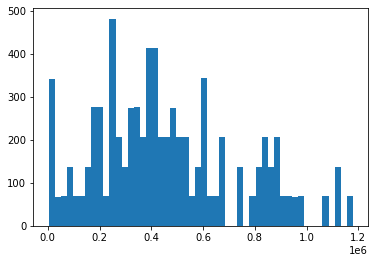

In [14]:
EG = TMG.Layers[-1]
Pzones = EG.NodeSize
Pzones = Pzones/np.sum(Pzones)
Entropy_Zone = -np.sum(Pzones*np.log2(Pzones))

Ptypes = EG.TypeFreq()[0] 
Entropy_Types=-np.sum(Ptypes*np.log2(Ptypes))
        
CondEntropy = Entropy_Zone-Entropy_Types

print(f"Ntypes: {EG.Ntypes} Nenv: {EG.N} Ez: {Entropy_Zone:.2f}" +  
      f"Et: {Entropy_Types:.2f} Log2(Nenv) {np.log2(EG.N):.2f}" + 
      f" Log2(Ntyp) {np.log2(EG.Ntypes):.2f}")

plt.hist(EG.NodeSize,bins=50)

In [7]:
TMG.Layers = TMG.Layers[0:3]
TMG.addEnvironmentLayer(5)

Treenomial mixture model training:


ValueError: Expected value argument (Tensor of shape (1268, 12)) to be within the support (Multinomial()) of the distribution Multinomial(), but found invalid values:
tensor([[3., 1., 0.,  ..., 0., 2., 3.],
        [4., 0., 0.,  ..., 0., 2., 4.],
        [1., 1., 0.,  ..., 0., 1., 6.],
        ...,
        [0., 4., 0.,  ..., 0., 6., 0.],
        [0., 4., 0.,  ..., 0., 6., 0.],
        [0., 3., 0.,  ..., 0., 6., 0.]], dtype=torch.float64)

In [36]:
Ent = [l.CondEntropy() for l in TMG.Layers]
print(Ent)

[9.936396985259988, 9.070439660222743, 8.929021197536057, 8.634925318506399]


[97786, 53448, 6983, 1991]


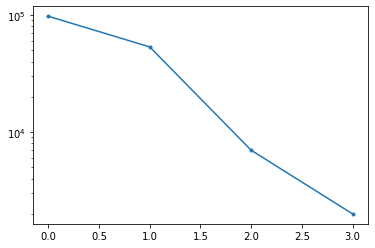

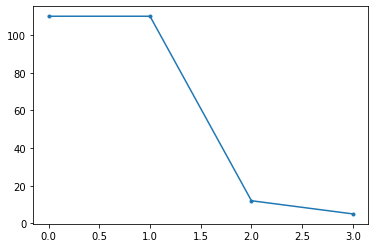

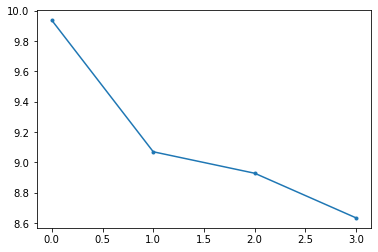

In [37]:
Ent = [l.CondEntropy() for l in TMG.Layers]
N = [l.N for l in TMG.Layers]
plt.semilogy(N,'.-')
print(N)
Ntypes =  [l.Ntypes for l in TMG.Layers]
plt.figure()
plt.plot(Ntypes,'.-')
plt.figure()
plt.plot(Ent,'.-')

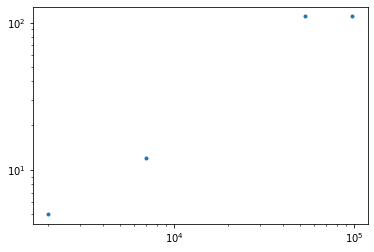

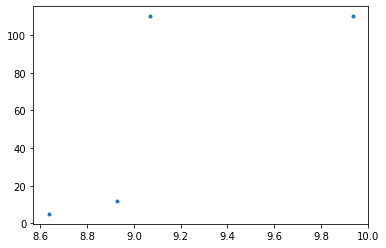

In [38]:
plt.figure()
plt.loglog(N,Ntypes,'.')
plt.figure()
plt.plot(Ent,Ntypes,'.')

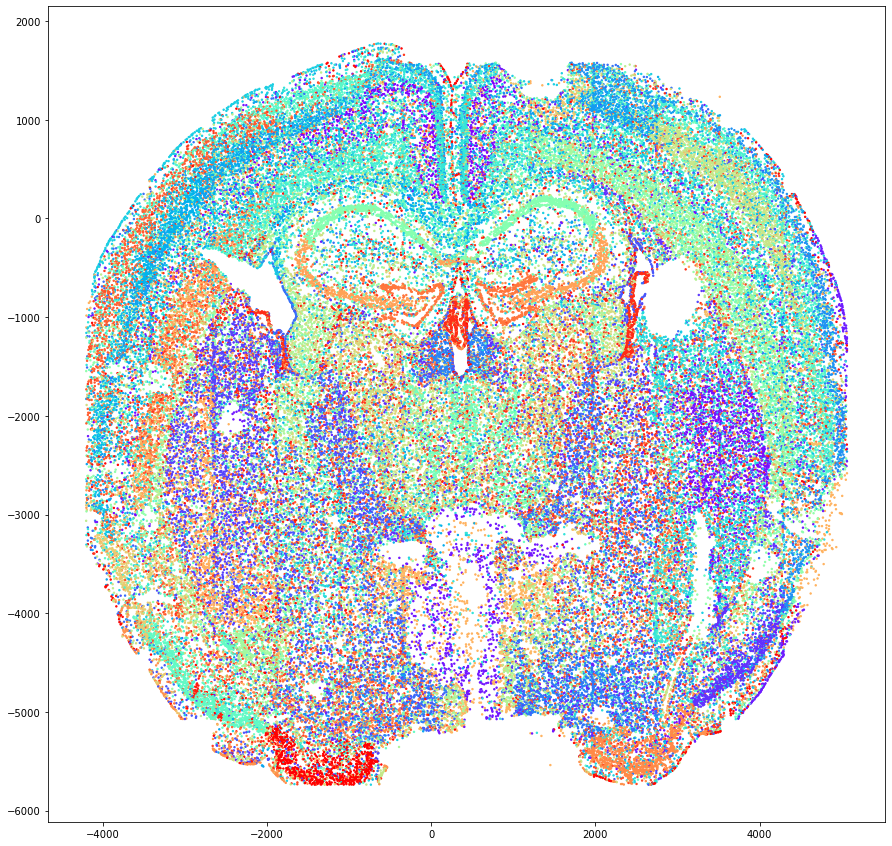

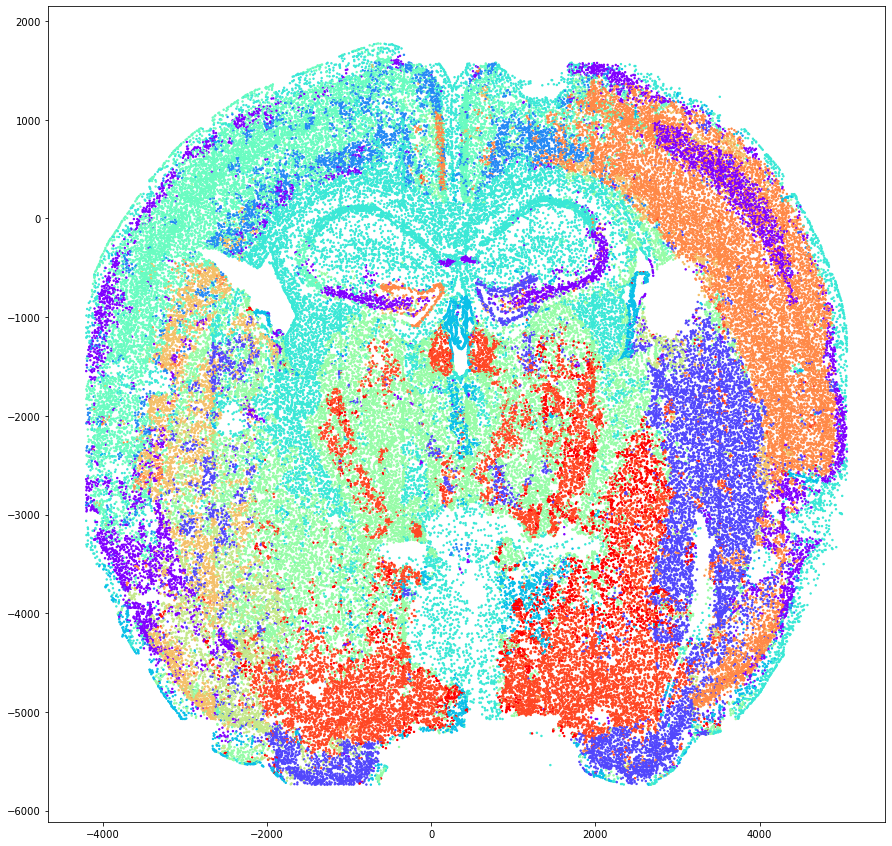

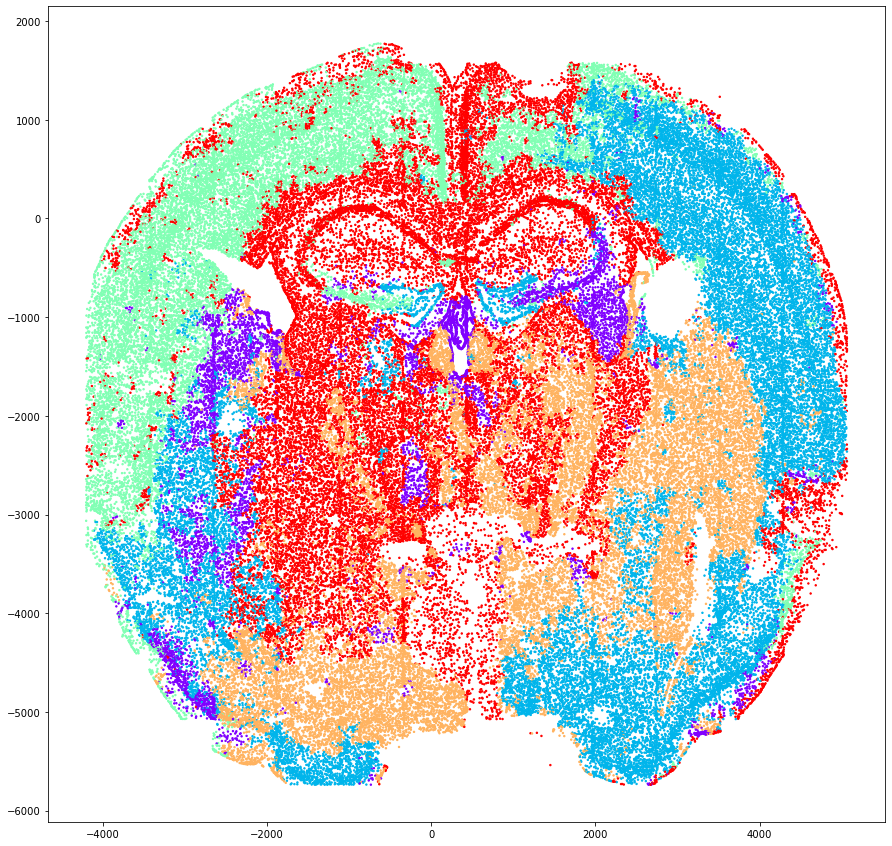

In [39]:
for i in range(1,len(TMG.Layers)): 
    TMG.scatter(i)